In [1]:
from __future__ import unicode_literals, print_function, division
from vocab import vocab, END_TOKEN, START_TOKEN, PADDING_TOKEN, UNKNOWN_TOKEN
from helpers import readLines
from load_data import load_data_evaluate, load_data_training
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import json

PHRASE_SIZE = 20
BATCH_SIZE = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# ENCODER

In [2]:
class EncoderRNN(nn.Module):
  def __init__(self, type_vocab, value_vocab, hidden_size, embedding_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.typeEmbedding = nn.Embedding(len(type_vocab), embedding_size, device=device)
    self.valueEmbedding = nn.Embedding(len(value_vocab), embedding_size, device=device)
    self.positionEmbedding = nn.Embedding(PHRASE_SIZE, 10, device=device)
    
    self.gru = nn.GRU(embedding_size * 2 + 10, self.hidden_size)

  def forward(self, inputs, hidden):
    E_type_out = self.typeEmbedding(inputs[0])
    E_value_out = self.valueEmbedding(inputs[1])
    E_pos_out = self.positionEmbedding(inputs[2])

    output = torch.cat((E_type_out, E_pos_out, E_value_out), dim=1).view(1, BATCH_SIZE, -1)

    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, BATCH_SIZE, self.hidden_size, device=device)

# DECODER

In [3]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size, device=device)
    
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    output = self.embedding(input)

    output = F.relu(output)
    
    output, hidden = self.gru(output, hidden)
    output = self.softmax(self.out(output[0]))
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, BATCH_SIZE, self.hidden_size, device=device)

# ATTENTION DECODER

In [4]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=PHRASE_SIZE):
    super(AttnDecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dropout_p = dropout_p
    self.max_length = max_length

    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
    self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1, BATCH_SIZE, -1)
    embedded = self.dropout(embedded)

    # print(embedded.shape, hidden.shape)
    # print(embedded[0].shape, hidden[0].shape)

    attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
    attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

    output = torch.cat((embedded[0], attn_applied[0]), 1)
    output = self.attn_combine(output).unsqueeze(0)

    output = F.relu(output)
    output, hidden = self.gru(output, hidden)

    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attn_weights

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

# TIMING & PLOT

In [5]:
import time
import math

def asMinutes(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)


def timeSince(since, percent):
  now = time.time()
  s = now - since
  es = s / (percent)
  rs = es - s
  return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  # this locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=0.5)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)
  plt.show()

# INPUT

In [6]:
type_vocab, value_vocab, token_vocab, pairs = load_data_training(torch, device, 50000, 5, 20, 100000)

too many pairs requested, new pair amount (articles / batch_size):  78523
------------------------
loading data: 7853/78523 (10.000891458553545%)
loading data: 15706/78523 (20.00178291710709%)
loading data: 23559/78523 (30.002674375660632%)
loading data: 31412/78523 (40.00356583421418%)
loading data: 39265/78523 (50.004457292767725%)
loading data: 47118/78523 (60.005348751321264%)
loading data: 54971/78523 (70.00624020987482%)
loading data: 62824/78523 (80.00713166842836%)
loading data: 70677/78523 (90.00802312698191%)
------------------------
pairs:  78496
batch size: 5, phrase size: 20
input shape:  torch.Size([3, 5, 20])
output shape:  torch.Size([5, 20])


# TRAINING

In [7]:
teacher_forcing_ratio = 0.5

# NOTE: inputs are (1, BATCH_SIZE)

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
  encoder_hidden = encoder.initHidden()

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(2) # == PHRASE_SIZE
  target_length = target_tensor.size(1)

  # NOTE: attention
  encoder_outputs = torch.zeros(PHRASE_SIZE, encoder.hidden_size, device=device)

  loss = 0

  for i in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[:,:,i], encoder_hidden)
    # NOTE: attention
    encoder_outputs[i] = encoder_output[0, 0]

  decoder_input = torch.tensor([[type_vocab.getID(START_TOKEN)] for _ in range(BATCH_SIZE)], device=device)
  decoder_input = decoder_input.view(1, BATCH_SIZE)

  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
  # use_teacher_forcing = True

  if use_teacher_forcing:
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
      # NOTE: attention
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      loss += criterion(decoder_output, target_tensor[:,di])
      decoder_input = target_tensor[:, di].view(1, BATCH_SIZE)  # Teacher forcing
      
  else:
    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
      # NOTE: attention
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach().view(1, BATCH_SIZE)  # detach from history as input

      loss += criterion(decoder_output, target_tensor[:,di])

  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length

In [8]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=5e-5):
  start = time.time()
  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0  # Reset every plot_every

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  training_pairs = [random.choice(pairs) for i in range(n_iters)]
  criterion = nn.NLLLoss()

  for iter in range(1, n_iters + 1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                      iter, iter / n_iters * 100, print_loss_avg))

    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0

  
  showPlot(plot_losses)


2m 17s (- 20m 35s) (1000 10%) 7.4212
4m 21s (- 17m 25s) (2000 20%) 6.7440
6m 27s (- 15m 4s) (3000 30%) 6.6572
8m 33s (- 12m 50s) (4000 40%) 6.5830
10m 40s (- 10m 40s) (5000 50%) 6.5033
12m 48s (- 8m 32s) (6000 60%) 6.4785
14m 55s (- 6m 23s) (7000 70%) 6.4487
17m 3s (- 4m 15s) (8000 80%) 6.3748
19m 9s (- 2m 7s) (9000 90%) 6.3438
21m 18s (- 0m 0s) (10000 100%) 6.3140


<Figure size 432x288 with 0 Axes>

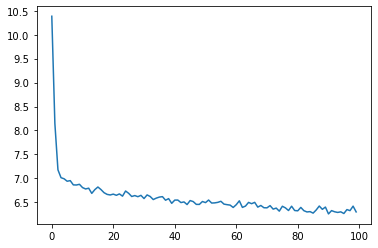

In [9]:

encoder = EncoderRNN(type_vocab, value_vocab, 256, 128).to(device)
# decoder = DecoderRNN(256, len(token_vocab)).to(device)
decoder = AttnDecoderRNN(256, len(token_vocab)).to(device)

trainIters(encoder, decoder, 10000, print_every=1000, plot_every=100)

# EVALUATION

In [10]:
type_vocab, value_vocab, token_vocab, inputs = load_data_evaluate(torch, device, 50000, BATCH_SIZE, PHRASE_SIZE, 1000)

# FIXME: not implemented yet
def evaluate(encoder, decoder, input_tensor, max_length=PHRASE_SIZE):
  with torch.no_grad():

    input_length = input_tensor.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] += encoder_output[0, 0]

    decoder_input = torch.tensor([[START_TOKEN]], device=device)  # SOS

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      decoder_attentions[di] = decoder_attention.data
      topv, topi = decoder_output.data.topk(1)
      if topi.item() == END_TOKEN:
        decoded_words.append('<EOS>')
        break
      else:
        decoded_words.append(token_vocab.index2word[topi.item()])

      decoder_input = topi.squeeze().detach()

    return decoded_words, decoder_attentions[:di + 1]

selected 1000 pairs out of 176796 available
------------------------
loading data: 100/1000 (10.0%)
loading data: 200/1000 (20.0%)
loading data: 300/1000 (30.0%)
loading data: 400/1000 (40.0%)
loading data: 500/1000 (50.0%)
loading data: 600/1000 (60.0%)
loading data: 700/1000 (70.0%)
loading data: 800/1000 (80.0%)
loading data: 900/1000 (90.0%)
loading data: 1000/1000 (100.0%)
------------------------
pairs:  1000
batch size: 5, phrase size: 20
input shape:  torch.Size([5, 20])
output shape:  torch.Size([5, 20])
